# Beta / Kumaraswamy Oracle Consensus Algorithms

In [28]:
import numpy as np
from typing import List, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

## Sample Data

In [29]:
def generate_beta_oracles(N_oracles, N_failing_oracles, a : float, b : float):
    oracles = [
        (np.random.beta(a, b), True)
        if i >= N_failing_oracles 
        else (np.random.uniform(0, 1), False)
        for i in range(N_oracles)
    ]

    np.random.shuffle(oracles)
    disjoint = tuple(map(list, zip(*oracles)))
    return disjoint

def generate_2d_beta_oracles(N_oracles, N_failing_oracles, a : Tuple[float], b : Tuple[float]):
    oracles = [
        (np.array([
            np.random.beta(a[0], b[0]),
            np.random.beta(a[1], b[1])
            ]), True)
        if i >= N_failing_oracles 
        else (np.array([
            np.random.uniform(0, 1),
            np.random.uniform(0, 1) 
            ]), False)
        for i in range(N_oracles)
    ]

    np.random.shuffle(oracles)
    # disjoint = tuple(map(list, zip(*oracles)))
    
    values, validity = zip(*oracles)

    return np.array(values), np.array(validity)

In [30]:
def kumaraswamy_mode(a : float, b : float) -> float:
    return ((a - 1) / (a*b - 1)) ** (1 / a)

def beta_mode(a : float, b:float) -> float:
    return (a - 1) / (a + b - 2)

#### Typical data

In [31]:
def plot_oracles_density(N_oracles, N_failing_oracles, a, b):
    # Generate oracles for each combination of true essence and true sigma
    oracles_sets = [
        generate_beta_oracles(N_oracles, N_failing_oracles, a[i], b[i])
        for i in range(len(a))
    ]

    # Set up the matplotlib figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))
    axes = axes.flatten()

    # Titles for each subplot
    titles = [f'a={a[i]:0.2f}, b={b[i]:0.2f}' for i in range(len(a))]


    # Plot each oracle set
    for i, (oracles, true_oracles) in enumerate(oracles_sets):
        oracle_values = np.array(oracles)
        sns.kdeplot(oracle_values, bw_adjust=0.5, fill=True, ax=axes[i])
        
        # Calculate statistics
        median_val = np.median(oracle_values)
        mean_val = np.mean(oracle_values)
        mode_val = beta_mode(a[i], b[i])

        # Add horizontal lines for median, mean, and mode
        axes[i].axvline(median_val, color='red', linestyle='--', linewidth=1, label=f'Median: {median_val:.2f}')
        axes[i].axvline(mean_val, color='green', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(mode_val, color='blue', linestyle='--', linewidth=1, label=f'Mode: {mode_val:.2f}')

        # Annotate the lines
        axes[i].legend()

        axes[i].set_xlim(0, 1)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Beta Oracle Value')
        axes[i].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

base_a = 10
a = np.array([base_a, base_a, base_a, base_a])
mirror = 1
b = np.array([base_a**mirror, base_a**-mirror, base_a, base_a**1.5])

plot_oracles_density(500, 60, a, b)


The median seems to be a good estimator for the mode.

### Samples for the Algorithm

In [32]:
N_oracles = 20
failing_percentage = 0.2
N_failing_oracles = round(N_oracles * failing_percentage)

In [33]:
a = 10

b_1d = 1
b_2d = [15, 30]

oracles, true_oracles = generate_beta_oracles(N_oracles, N_failing_oracles, a, a)
oracles_2d, true_oracles_2d = generate_2d_beta_oracles(
    N_oracles, N_failing_oracles, [a, a], [15, 15])

true_essence_1d = beta_mode(a, b_1d)
true_essence_2d = (beta_mode(a, b_2d[0]), beta_mode(a, b_2d[1]))

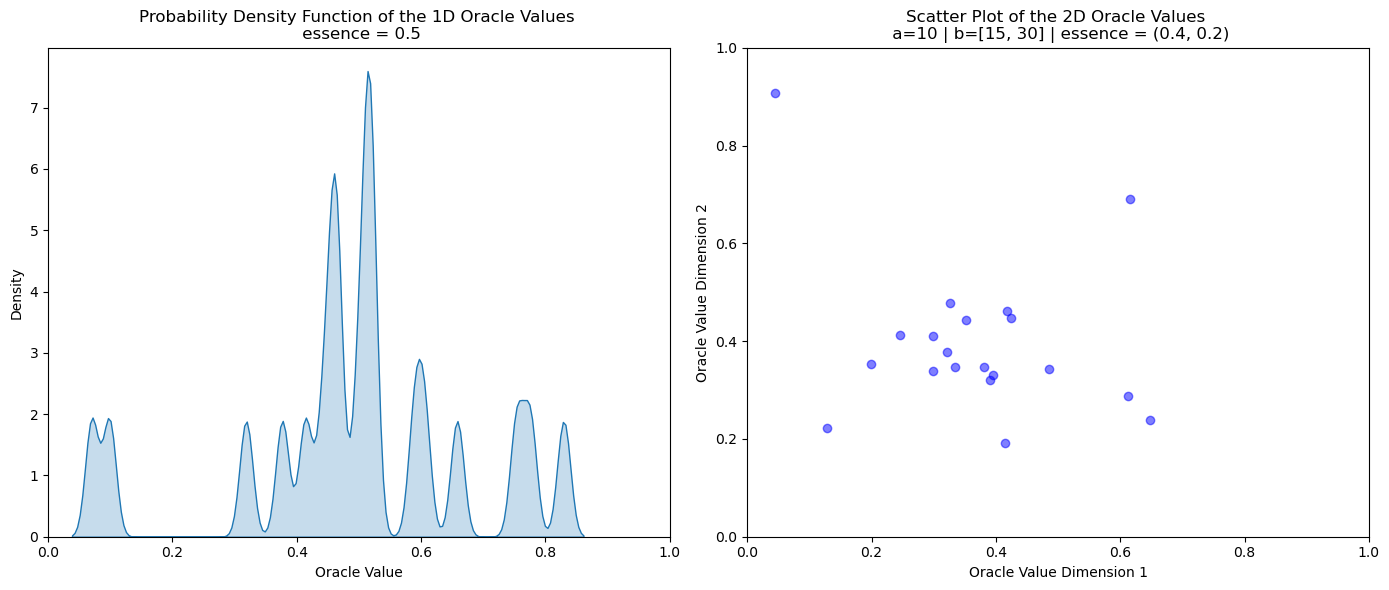

In [34]:
def plot():
    oracle_values = np.array(oracles)
    oracle_values_2d = oracles_2d
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.kdeplot(oracle_values, bw_adjust=0.1, fill=True, ax=axs[0])
    axs[0].set_xlim(0, 1)
    axs[0].set_title('Probability Density Function of the 1D Oracle Values \n essence = 0.5')
    axs[0].set_xlabel('Oracle Value')
    axs[0].set_ylabel('Density')
    
    axs[1].scatter(oracle_values_2d[:, 0], oracle_values_2d[:, 1], c='b', alpha=0.5)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(0, 1)

    string_2d_essence = f'({true_essence_2d[0]:0.01f}, {true_essence_2d[1]:0.01f})'
    axs[1].set_title(f'Scatter Plot of the 2D Oracle Values \n a={a} | b={b_2d} | essence = {string_2d_essence}')
    axs[1].set_xlabel('Oracle Value Dimension 1')
    axs[1].set_ylabel('Oracle Value Dimension 2')
    
    plt.tight_layout()
    plt.show()

plot()

In [35]:
def to_wsad(x : float) -> float:
    return int(x * 1e6)

In [36]:
def reliability(std : float) -> float :
    return 1 - 2*std

def expected_reliability(arr : np.array) -> float :
    a = np.abs(arr - np.median(arr))
    b = np.mean(a)

    return reliability(b)

In [37]:
print(f"first pass reliability approximation : {expected_reliability(oracles):0.3f}")
print([to_wsad(x) for x in oracles])

first pass reliability approximation : 0.733
[604648170803978112, 513368798347255552, 413668005160597760, 518023571584783936, 463764194143121792, 457889891797436672, 318407698322946048, 497108965873311296, 829376519607807744, 775187564742576640, 657975195868351104, 589316922905633920, 462726469584834176, 70051909587770408, 442419668120294080, 376641898155035584, 753482678347486848, 520518810096292288, 512885297033408448, 98431742337213632]


In [38]:
print(f"first pass reliability approximation : {expected_reliability(oracles_2d):0.3f}")
for (x, y) in oracles_2d :
    print(f"array![{to_wsad(x)}, {to_wsad(y)}].span(), ") 

first pass reliability approximation : 0.788
array![611793070279667840, 287760301278265024].span(), 
array![381110986655657216, 347877040592544192].span(), 
array![321668864146701888, 378303300227197568].span(), 
array![198883505784980288, 352476127517653632].span(), 
array![298775647931894400, 411472613529957504].span(), 
array![334921151825770880, 346202226326343936].span(), 
array![485651841471654144, 343663612534465984].span(), 
array![418431642282382336, 461360045212313664].span(), 
array![352150147913416832, 442426926211080512].span(), 
array![325678357678512256, 477842581958276096].span(), 
array![127462554998934000, 223046233115834720].span(), 
array![389947020246216512, 319517842791302336].span(), 
array![246337928212220576, 411655030170698240].span(), 
array![298706120767065344, 338947212221641472].span(), 
array![395501677494134464, 330652842296637248].span(), 
array![45307088306999696, 908141986734113664].span(), 
array![647641444123717504, 237686762331333664].span(), 
arra